To do before submitting 
- check status of the table of contents (all corretly linked?)
- once import statemtn is final move it to the cells where i open the pickle files
- the columns that I end up removing before imputing maybe put them in the cleaning function, then may need to repickle

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

## Table of Contents

1. [Introduction](#intro)
2. [Part 0: Get to Know the Data](#part0)  
  2.1 [Encode Missing or Unknown Values](#part0unknowns)<br>
  2.2 [Assess Missing Data in Columns and Rows](#part0missing)<br>
  2.3 [Select and Re-Encode Features](#part0reencode)<br>
  2.4 [Create a Cleaning Function](#part0clean)<br>
  2.5 [Impute Missing Values](#part0impute)<br>
3. [Part 1: Customer Segmentation Report](#part1)
4. [Part 2: Supervised Learning Model](#part2)
5. [Part 3: Kaggle Competition](#part3)
6. [Conclusions](#conclusions)  
7. [Resources](#resources)

<a id='intro'></a> 
## Introduction

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn.preprocessing import Imputer, StandardScaler

# magic word for producing visualizations in notebook
%matplotlib inline

<a id='part0'></a>
## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

<a id='part0unknowns'></a>
### Encode missing or unknown values 

In [2]:
# load in the azdias dataset 
azdias = pd.read_csv('azdias.csv')
del azdias['Unnamed: 0']

C:\Users\ursula\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Print number of rows and columns in the azdias dataframe
azdias.shape

(891221, 366)

In [4]:
# Print first 5 rows of the azdias dataframe
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
# Determine number of non-null values for each column of the azdias dataframe
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
for col in azdias.columns:
    if azdias[col].dtype == np.int64:
        azdias[col] = azdias[col].astype(np.float64)

LNR
AGER_TYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP_MAX
D19_KOSMETIK
D19_LEBENSMITTEL
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_TECHNIK
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_REST
D19_TIERARTIKEL
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_REST
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
D19_VERSI_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERS

In [7]:
# Generate descriptive statistics that summarize the azdias dataframe
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


In [8]:
# Load the feature information and view the first 15 lines
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del feat_info['Unnamed: 0']
feat_info.head(15)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,1,< 30 years
7,NaN,NaN,2,30 - 45 years
8,NaN,NaN,3,46 - 60 years
9,NaN,NaN,4,> 60 years


In [9]:
# It looks like the first 5 columns are for AGER_TYP (and so on) but only the first row of the
# attribute column is filled in and the rest are NaNs.  Therefore, forward this column, redefine
# this as the attribute column, and view the first 10 lines of the altered dataframe. 
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [10]:
# I want to find all the encoded values that are actually missing or unknown values that should 
# be converted to NaNs.  Therefore, subset the meaning column to contain only those values 
# containing "unknown" or "no " (such as "no classification possible"), then view the altered
# dataframe.  After scanning I do not see any abberent descriptions.  
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 500)
feat_info

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown
49,BIP_FLAG,NaN,0,no company in the building
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown


In [11]:
# Convert the value column to be a string or a list of strings
feat_info.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [12]:
# Because both of the first 2 rows of feat_info belong to the same attribute, combine the values 
# for each row into a single list of strings

unknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
unknowns

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
5,BIP_FLAG,"[-1, 0]"
6,CAMEO_DEUG_2015,[-1]
7,CAMEO_DEUINTL_2015,[-1]
8,CJT_GESAMTTYP,[0]
9,D19_BANKEN_ANZ_12,[0]


In [13]:
# Using the unknown dataframe, identify missing or unknown data values and convert them to NaNs.

start = time.time()
    
for row in unknowns['attribute']:
    print(row)
    if row in azdias.columns:
        na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_idx = azdias.loc[:, row].isin(na_map)
        azdias.loc[na_idx, row] = np.NaN
    else:
        continue

end = time.time()
elapsed = end - start
elapsed

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

13.530786991119385

In [14]:
# View the altered azdias dataframe.  The 1st, 2nd, 3rd, and 5th rows of the AGER_TYP column 
# have now been converted from -1 to NaN. 
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [15]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias, open("azdias.pickle", "wb"))

In [16]:
# Dump the unknowns dataframe to a pickle object in case we need it later.
pickle.dump(unknowns, open("unknowns.pickle", "wb"))

<a id='part0missing'></a>
### Assess Missing Data in Columns and Rows

In [2]:
# Reload azdias object as saved after above analysis (may need to rerun imports)
azdias = pickle.load(open("azdias.pickle", "rb"))

In [3]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_na = azdias.shape[0] - azdias.count()
col_na.sort_values()

LNR                                 0
D19_WEIN_FEINKOST                   0
D19_VOLLSORTIMENT                   0
D19_VERSICHERUNGEN                  0
D19_VERSI_ONLINE_DATUM              0
D19_VERSI_OFFLINE_DATUM             0
D19_VERSI_DATUM                     0
D19_VERSAND_REST                    0
D19_TIERARTIKEL                     0
D19_TELKO_REST                      0
D19_TELKO_MOBILE                    0
D19_TECHNIK                         0
D19_SONSTIGE                        0
D19_SCHUHE                          0
D19_SAMMELARTIKEL                   0
D19_REISEN                          0
D19_RATGEBER                        0
D19_NAHRUNGSERGAENZUNG              0
D19_LEBENSMITTEL                    0
D19_KOSMETIK                        0
D19_KONSUMTYP_MAX                   0
D19_KINDERARTIKEL                   0
FINANZ_ANLEGER                      0
FINANZ_HAUSBAUER                    0
FINANZ_MINIMALIST                   0
FINANZ_SPARER                       0
ZABEOTYP    

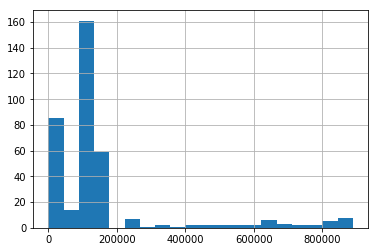

In [4]:
# Investigate patterns in the amount of missing data in each column.
col_na.hist(bins=20);

In [5]:
# Remove columns which have > 200000 missing values
cols_to_drop = azdias.columns[col_na > 200000]
print(cols_to_drop)
azdias.drop(cols_to_drop, axis=1, inplace = True)
azdias.shape

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3'

(891221, 319)

The azdias dataframe originally had 366 columns and now has 319 columns, meaning that 47 columns (13%) were dropped from the dataframe based on having >200000 NaNs.  Many of these columns start with "D19" which have to do with transaction activity.  

In [6]:
# How much data is missing in each row of the dataset?
# Create series containing number of missing rows and print a few rows
row_na = azdias.shape[1] - azdias.count(axis = 1)
row_na.head()

0    233
1      0
2      0
3      4
4      0
dtype: int64

In [7]:
# Generate descriptive statistics on number of missing rows
row_na.describe()

count    891221.000000
mean         30.067767
std          71.995554
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         242.000000
dtype: float64

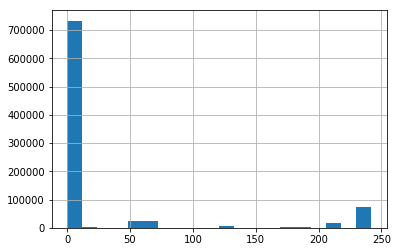

In [8]:
# Plot histogram of number of missing values
row_na.hist(bins=20);

In [9]:
# Remove rows which contain more than 10 missing values per row
rows_to_drop = azdias.index[row_na > 10]
azdias.drop(rows_to_drop, axis=0, inplace = True)
azdias.shape

(732489, 319)

The azdias dataframe originally had 891221 rows and now has 732489 rows, meaning that 158732 rows (18%) were dropped from the dataframe based on having > 10 NaNs.

In [10]:
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


<a id='part0reencode'></a>
### Select and Re-Encode Features

Info from the Term 1 project: Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

For this project we are not supplied with a column that encodes how the data is encoded therefore I manually looked through the 
Attributes excel sheet and noted down which columns looked like either categorical or mixed and saved them into the variable "categorical" below.  

In [11]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# For every column which is encoded as "categorical" in the feat_info dataset
# print the value counts
        
for i in categorical:
    if i in azdias.columns:
        print(azdias[i].value_counts())

2.0    381860
1.0    350629
Name: ANREDE_KZ, dtype: int64
6B    53656
8A    50490
4C    43671
2D    32660
7A    32410
3C    32326
3D    31947
8B    31078
4A    30043
8C    29976
9D    26589
9B    25763
7B    22793
9C    22785
9A    19953
2C    17620
8D    16584
6E    15485
5D    13976
2B    13945
6C    13789
2A    11824
1D    11383
1A    10097
5A     9663
5B     9628
5C     8993
4B     8232
7C     8082
4D     8008
6A     6377
3A     5828
6D     5723
3B     5669
6F     5027
4E     4977
1E     4758
7D     4402
7E     4346
1C     3989
5F     3912
9E     3825
1B     3792
5E     3227
XX      282
Name: CAMEO_DEU_2015, dtype: int64
4.0    182228
3.0    135120
2.0    133711
5.0    104670
6.0     92035
1.0     84725
Name: CJT_GESAMTTYP, dtype: int64
6.0    277499
1.0    182264
5.0     97317
2.0     93587
4.0     52173
3.0     29649
Name: FINANZTYP, dtype: int64
1.0    419425
3.0    162109
8.0    145347
2.0      4231
4.0       820
6.0       556
5.0         1
Name: GEBAEUDETYP, dtype: int64
4.0  

In [13]:
# The only binary categorical variable that does not take 
# integer values is OST_WEST_KZ which uses either W or O
# will be re-encoded with 1 and 0.  Other binary categorical
# variables will be lest as is. 

azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [14]:
# If column has less than 10 levels, re-encode using dummy variables.
# If column has equal to or more than 10 different values, drop for
# simplicity. Make lists of these columns to be used below.

cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [15]:
# Drop categorical columns with 10 or more values
azdias.drop(cat_cols_to_drop, axis=1, inplace = True)
azdias.shape

(732489, 312)

In [16]:
# Create dummy variables for columns with less than 10 
# unique values then drop the original columns
for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)

print(azdias.shape)

azdias.drop(cat_cols_to_dummy, axis=1, inplace = True)

azdias.shape

(732489, 375)


(732489, 362)

In [17]:
# View first few lines of the altered dataset (including the dummary variables at
# the end of the dataframe)
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0,1,0,0,0,0,0,1,0,1
2,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0,1,0,0,0,0,1,0,1,0
3,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0,1,0,0,0,1,0,0,1,0
4,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0,1,0,0,0,0,1,0,0,1
5,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0,1,0,0,1,0,0,0,0,1


<a id='part0clean'></a> 
### Create a Cleaning Function

Create a cleaning function with the steps that were performed on the azdias dataframe so they can also be apploed to the customer demographics data. 

In [18]:
# Create a cleaning function so the same changes can be 
# easily done on the customer dataset as it was on the
# general population dataset.  Since above I performed 
# various creations of dummy variables and droppings of 
# columns, these were simplified so that they are all 
# performed at the same time.

def clean_data(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df1: Customer demographics DataFrame
        df2: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for col in df1.columns:
        if df1[col].dtype == np.int64:
            df1[col] = df1[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in unknowns['attribute']:
        if row in df1.columns:
            na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
            
    # remove selected columns, ...
    # These columns were the ones above that had
    # > 200000 missing values in the azdias dataframe
    cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # remove selected rows, ...
    # These are rows which have >25 missing values
    row_na = df1.shape[1] - df1.count(axis = 1)
    rows_to_drop = df1.index[row_na > 10]
    df1.drop(rows_to_drop, axis=0, inplace = True)
    
    # select, re-encode, and engineer column values
    df1['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df1[col], prefix = col)
        df1 = pd.concat([df1, dummy], axis = 1)
        
    df1.drop(cols_to_dummy, axis=1, inplace = True)
    
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # Return the cleaned dataframe.
    return df1

In [19]:
# load in the customers dataset 
customers = pd.read_csv('customers.csv')
del customers['Unnamed: 0']

C:\Users\ursula\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# Determine the shape of the customers dataframe
customers.shape

(191652, 369)

In [21]:
# View the first few lines of the customers dataframe
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [22]:
# Investigate the CUSTOMER_GROUP column
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [23]:
# Investigate the ONLINE_PURCHASE column
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [24]:
# Investigate the PRODUCT_GROUP column
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [25]:
# View count of these 3 extra columns (there are no NaNs)
customers['CUSTOMER_GROUP'].count(), customers['ONLINE_PURCHASE'].count(), customers['PRODUCT_GROUP'].count()

(191652, 191652, 191652)

In [26]:
# Reload unknowns object as saved after above analysis
unknowns = pickle.load(open("unknowns.pickle", "rb"))

In [27]:
# Run the clean_data function on the azdias dataset
customers = clean_data(customers, unknowns)

In [28]:
# Determine the shape of the customers dataframe after cleaning
customers.shape

(131204, 364)

In [29]:
# View the first few lines of the customers dataframe after cleaning
customers.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,9626.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,1,1,0,0,0,0,0,1,1,0
2,143872.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,1,1,0,0,0,1,0,0,0,1
3,143873.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,0,1,0,0,1,0,0,0,1,0
4,143874.0,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,0,1,0,0,0,1,0,0,0,1
5,143888.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,0,1,0,0,0,1,0,0,0,1


In [30]:
# Determine the columns that are in the cleaned customers dataframe
# but not the cleaned azdias dataframe (these 3 are expected)
customers.columns[~customers.columns.isin(azdias.columns)]

Index(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], dtype='object')

In [31]:
# Determine the columns that are in the cleaned azdias dataframe
# but not the cleaned customers dataframe
azdias.columns[~azdias.columns.isin(customers.columns)]

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [32]:
# Find index of the GEBAEUDETYP_5.0 column in the azdias dataframe
column_index = azdias.columns.get_loc("GEBAEUDETYP_5.0")
column_index

315

In [33]:
# Insert a column called GEBAEUDETYP_5.0 at index = 315
# with all values = 0
customers.insert(loc=column_index, column='GEBAEUDETYP_5.0', value=0)

In [34]:
# Determine that the number of columns match for the dataframes (taking
# into accont the extra 3 columns)
customers.shape[1] == azdias.shape[1] + 3

True

In [35]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias, open("azdias_clean.pickle", "wb"))

# Dump the customers dataframe to a pickle object to use for later.
pickle.dump(customers, open("customers_clean.pickle", "wb"))

<a id='part0impute'></a> 
## Impute Missing Values

In [3]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_clean = pickle.load(open("azdias_clean.pickle", "rb"))

# Reload cleaned customers object as saved after above analysis
customers_clean = pickle.load(open("customers_clean.pickle", "rb"))

In [4]:
# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have values that strings "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del azdias_clean['CAMEO_DEUG_2015']
del azdias_clean['CAMEO_INTL_2015']
del azdias_clean['EINGEFUEGT_AM']
del customers_clean['CAMEO_DEUG_2015']
del customers_clean['CAMEO_INTL_2015']
del customers_clean['EINGEFUEGT_AM']

In [5]:
for col in azdias_clean.columns:
    print(azdias_clean[col].value_counts())

524287.0    1
814227.0    1
814249.0    1
814248.0    1
814247.0    1
814246.0    1
814245.0    1
814244.0    1
814243.0    1
814242.0    1
203560.0    1
814239.0    1
888288.0    1
203559.0    1
814235.0    1
814234.0    1
814233.0    1
814232.0    1
814231.0    1
814230.0    1
814229.0    1
814250.0    1
814251.0    1
203563.0    1
814266.0    1
203569.0    1
254159.0    1
814274.0    1
203568.0    1
198286.0    1
           ..
290043.0    1
257938.0    1
290041.0    1
290040.0    1
840688.0    1
290039.0    1
290038.0    1
290058.0    1
605497.0    1
290078.0    1
918252.0    1
290076.0    1
290075.0    1
290074.0    1
290073.0    1
290072.0    1
198833.0    1
290071.0    1
290069.0    1
877305.0    1
290060.0    1
290067.0    1
290066.0    1
290064.0    1
622379.0    1
290063.0    1
290062.0    1
290061.0    1
870821.0    1
524289.0    1
Name: LNR, Length: 732489, dtype: int64
1.0    352007
9.0    242829
5.0     25329
6.0     24685
3.0     21827
4.0     18824
7.0     18418
8.0     

0.0    697937
6.0     17896
7.0      7011
3.0      5345
5.0      3372
2.0       481
4.0       407
1.0        40
Name: D19_TIERARTIKEL, dtype: int64
0.0    593752
6.0     61253
3.0     34871
5.0     22141
2.0      6682
7.0      5161
4.0      4362
1.0      4267
Name: D19_VERSAND_REST, dtype: int64
10.0    526892
9.0      71880
8.0      32292
5.0      25895
6.0      20548
7.0      18756
2.0      14124
4.0       8547
1.0       7690
3.0       5865
Name: D19_VERSI_DATUM, dtype: int64
10.0    703009
9.0      15982
8.0       6252
5.0       3079
7.0       1711
6.0       1422
4.0        497
3.0        188
2.0        184
1.0        165
Name: D19_VERSI_OFFLINE_DATUM, dtype: int64
10.0    725852
9.0       2470
8.0       1128
7.0        943
5.0        889
6.0        609
4.0        265
2.0        123
3.0        116
1.0         94
Name: D19_VERSI_ONLINE_DATUM, dtype: int64
0.0    521512
6.0    104172
3.0     39911
5.0     27553
2.0     13190
4.0     11751
1.0      9020
7.0      5380
Name: D19_VERSICHE

3.0    318348
2.0    150361
4.0    141791
1.0     61121
5.0     60868
Name: KBA05_SEG4, dtype: int64
1.0    232013
2.0    180873
0.0    180061
3.0     89669
4.0     49873
Name: KBA05_SEG5, dtype: int64
0.0    645422
1.0     87067
Name: KBA05_SEG6, dtype: int64
0.0    362852
1.0    181422
2.0    139146
3.0     49069
Name: KBA05_SEG7, dtype: int64
0.0    398148
1.0    171414
2.0    118496
3.0     44431
Name: KBA05_SEG8, dtype: int64
0.0    253695
1.0    237588
2.0    185504
3.0     55702
Name: KBA05_SEG9, dtype: int64
3.0    240445
2.0    170776
4.0    159925
1.0    105393
5.0     55950
Name: KBA05_VORB0, dtype: int64
3.0    305916
2.0    151097
4.0    146660
5.0     64666
1.0     64150
Name: KBA05_VORB1, dtype: int64
3.0    231477
2.0    158642
4.0    118432
5.0     87063
1.0     83478
0.0     53397
Name: KBA05_VORB2, dtype: int64
3.0    295227
4.0    155924
2.0    154849
1.0     66645
5.0     59844
Name: KBA05_ZUL1, dtype: int64
3.0    284602
2.0    163966
4.0    157768
1.0     63610
5

3.0    258498
2.0    150827
0.0    131342
4.0     82268
5.0     70709
1.0     38845
Name: KBA13_KMH_211, dtype: int64
3.0    259336
2.0    150286
0.0    131575
4.0     82216
5.0     70149
1.0     38927
Name: KBA13_KMH_250, dtype: int64
1.0    630751
3.0     92895
2.0      8843
Name: KBA13_KMH_251, dtype: int64
3.0    303875
2.0    162705
4.0    131731
1.0     85178
5.0     49000
Name: KBA13_KRSAQUOT, dtype: int64
3.0    314020
2.0    157091
4.0    150435
1.0     62172
5.0     48771
Name: KBA13_KRSHERST_AUDI_VW, dtype: int64
3.0    321937
4.0    153695
2.0    143530
5.0     68566
1.0     44761
Name: KBA13_KRSHERST_BMW_BENZ, dtype: int64
3.0    306867
4.0    156029
2.0    146991
5.0     61736
1.0     60866
Name: KBA13_KRSHERST_FORD_OPEL, dtype: int64
2.0    669959
1.0     33014
3.0     29507
0.0         9
Name: KBA13_KRSSEG_KLEIN, dtype: int64
2.0    481254
1.0    143753
3.0    107242
0.0       240
Name: KBA13_KRSSEG_OBER, dtype: int64
2.0    455039
1.0    158272
3.0    118599
0.0       

2.0    131421
5.0    125302
4.0    123061
7.0    105888
6.0     92704
3.0     90033
1.0     64080
Name: SEMIO_FAM, dtype: int64
3.0    166687
7.0    121229
6.0    117209
5.0    116334
2.0     98951
4.0     68065
1.0     44014
Name: SEMIO_KAEM, dtype: int64
5.0    141801
4.0    136484
6.0    125642
3.0    116711
7.0    113343
2.0     53264
1.0     45244
Name: SEMIO_KRIT, dtype: int64
5.0    159971
3.0    122894
1.0    105916
7.0    104868
6.0     98170
4.0     87399
2.0     53271
Name: SEMIO_KULT, dtype: int64
6.0    150193
7.0    146458
1.0     95655
2.0     90336
4.0     87864
5.0     81960
3.0     80023
Name: SEMIO_LUST, dtype: int64
4.0    141866
2.0    119487
3.0    114999
7.0     99523
1.0     94038
5.0     90431
6.0     72145
Name: SEMIO_MAT, dtype: int64
3.0    127482
4.0    117916
5.0    110958
7.0    110256
6.0    107871
2.0     88698
1.0     69308
Name: SEMIO_PFLICHT, dtype: int64
4.0    226895
2.0    134904
3.0    126130
7.0     82728
5.0     75194
6.0     49815
1.0     3682

In [6]:
azdias_clean.shape, customers_clean.shape

((732489, 359), (131204, 362))

In [7]:
# Make a new dataframe to hold the 3 extra columns of the customers dataset in case we need 
# them for later
customers_extra_cols = customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers_extra_cols.head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0.0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0.0
3,COSMETIC,MULTI_BUYER,0.0
4,FOOD,MULTI_BUYER,0.0
5,COSMETIC_AND_FOOD,MULTI_BUYER,0.0


In [8]:
# Delete the 3 extra columns from the customers dataframe so it has the same columns
# as the azdias dataframe
del customers_clean['PRODUCT_GROUP']
del customers_clean['CUSTOMER_GROUP']
del customers_clean['ONLINE_PURCHASE']
customers_clean.shape

(131204, 359)

In [9]:
# Impute the missing values using the mean 
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(imputer.fit_transform(customers_clean), columns = customers_clean.columns)

C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [11]:
# View number of NaNs per column of the azdias_clean df (now all should be 0)
(azdias_clean.shape[0] - azdias_clean.count()).sort_values()

LNR                     0
KOMBIALTER              0
KKK                     0
KBA13_VW                0
KBA13_VORB_3            0
KBA13_VORB_2            0
KBA13_VORB_1_2          0
KBA13_VORB_1            0
KBA13_VORB_0            0
KONSUMNAEHE             0
KBA13_TOYOTA            0
KBA13_SITZE_5           0
KBA13_SITZE_4           0
KBA13_SEG_WOHNMOBILE    0
KBA13_SEG_VAN           0
KBA13_SEG_UTILITIES     0
KBA13_SEG_SPORTWAGEN    0
KBA13_SEG_SONSTIGE      0
KBA13_SEG_OBERKLASSE    0
KBA13_SITZE_6           0
KONSUMZELLE             0
MIN_GEBAEUDEJAHR        0
MOBI_RASTER             0
SEMIO_ERL               0
SEMIO_DOM               0
RT_UEBERGROESSE         0
RT_SCHNAEPPCHEN         0
RT_KEIN_ANREIZ          0
RETOURTYP_BK_S          0
RELAT_AB                0
                       ..
KBA05_KRSZUL            0
KBA05_KRSVAN            0
KBA05_KRSOBER           0
KBA05_KRSKLEIN          0
KBA05_KRSHERST3         0
KBA05_MAXAH             0
KBA05_SEG10             0
KBA05_SEG2  

In [12]:
# View number of NaNs per column of the customers_clean df (now all should be 0)
(customers_clean.shape[0] - customers_clean.count()).sort_values()

LNR                     0
KOMBIALTER              0
KKK                     0
KBA13_VW                0
KBA13_VORB_3            0
KBA13_VORB_2            0
KBA13_VORB_1_2          0
KBA13_VORB_1            0
KBA13_VORB_0            0
KONSUMNAEHE             0
KBA13_TOYOTA            0
KBA13_SITZE_5           0
KBA13_SITZE_4           0
KBA13_SEG_WOHNMOBILE    0
KBA13_SEG_VAN           0
KBA13_SEG_UTILITIES     0
KBA13_SEG_SPORTWAGEN    0
KBA13_SEG_SONSTIGE      0
KBA13_SEG_OBERKLASSE    0
KBA13_SITZE_6           0
KONSUMZELLE             0
MIN_GEBAEUDEJAHR        0
MOBI_RASTER             0
SEMIO_ERL               0
SEMIO_DOM               0
RT_UEBERGROESSE         0
RT_SCHNAEPPCHEN         0
RT_KEIN_ANREIZ          0
RETOURTYP_BK_S          0
RELAT_AB                0
                       ..
KBA05_KRSZUL            0
KBA05_KRSVAN            0
KBA05_KRSOBER           0
KBA05_KRSKLEIN          0
KBA05_KRSHERST3         0
KBA05_MAXAH             0
KBA05_SEG10             0
KBA05_SEG2  

<a id='part1'></a>
## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

<a id='part2'></a>
## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [23]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: File b'../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv' does not exist

In [ ]:
mailout_train.to_csv('train.csv')

<a id='part3'></a>
## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
mailout_test.to_csv('test.csv')

<a id='conclusions'></a>
## Conclusions

<a id='resources'></a>
## Resources